# Proyecto Final 
---
Me han asignado una tarea analítica compleja que mis predecesores dejaron a medias. Parece que se entusiasmaron con la idea de cultivar sandías en Brasil y me dejaron con un proyecto de comercio electrónico sin terminar. Afortunadamente, conté con la exhaustividad de mis colegas anteriores, quienes dejaron un detallado informe con las especificaciones técnicas de la prueba A/B que iniciaron y los resultados preliminares. Ahora, mi objetivo es retomar esta investigación, analizar a fondo los datos recabados y extraer conclusiones valiosas para optimizar la tienda en línea y alcanzar los objetivos de negocio establecidos.

### 1. Objetivo del proyecto 
---
- Verificar los datos de prueba del test A/B para comprobar que se ha hecho correctamente
- Localizar embudos 
- Analizar resultados 

### 2. Descripción de técnica de resultados 
---
- Nombre de la prueba: `recommender_system_test`
- Grupos: А (control), B (nuevo embudo de pago)
- Launch date: 2020-12-07
- Fecha en la que dejaron de aceptar nuevos usuarios: 2020-12-21
- Fecha de finalización: 2021-01-01
- Audiencia: 15% de los nuevos usuarios de la región de la UE
- Propósito de la prueba: probar cambios relacionados con la introducción de un sistema de recomendaciones mejorado
- Resultado esperado: dentro de los 14 días posteriores a la inscripción, los usuarios mostrarán una mejor conversión en vistas de la página del producto (el evento `product_page`), instancias de agregar artículos al carrito de compras (`product_card`) y compras (`purchase`). En cada etapa del embudo `product_page → product_card → purchase`, habrá al menos un 10% de aumento.
- Número previsto de participantes de la prueba: 6 000

### 3. Descripción de datos 
---
- `ab_project_marketing_events_us.csv`: el calendario de eventos de marketing para 2020
- `final_ab_new_users_upd_us.csv`: todos los usuarios que se registraron en la tienda en línea desde el 7 hasta el 21 de diciembre de 2020
- `final_ab_events_upd_us.csv`: todos los eventos de los nuevos usuarios en el período comprendido entre el 7 de diciembre de 2020 y el 1 de enero de 2021
- `final_ab_participants_upd_us.csv`: tabla con los datos de los participantes de la prueba

### 4. Descarga de datos
---

In [64]:
#Importación de librerías necesarias
import pandas as pd
import seaborn as sns
import numpy as np
import math as mth
from datetime import datetime
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
#Carga y asignación de variables a datasets
project_mkt= pd.read_csv('ab_project_marketing_events_us.csv', sep=',')
events= pd.read_csv('final_ab_events_upd_us.csv', sep=',')
new_users= pd.read_csv('final_ab_new_users_upd_us.csv', sep=',')
participants= pd.read_csv('final_ab_participants_upd_us.csv', sep=',')

In [3]:
# Visualización e información de dataset 'project_mkt'
project_mkt.info()
project_mkt.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 580.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


En este primer dataset se puede observar que no hay valores ausentes y cuenta con 14 filas. Será necesario convertir los datos de las columnas 'start_dt' y 'finish_dt' a datetime.

In [4]:
# Visualización e información de dataset 'events'
events.info()
events.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 12.9+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


En este dataset podemos ver que en la columna de 'details' existen muchos valores ausentes. La columna 'event_dt' tendrá que ser cambiada a tipo de dato 'datetime'

In [5]:
# Visualización e información de dataset 'new_users'
new_users.info()
new_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


En este dataset, no hay valores ausentes. Hay que cambiar el tipo de datos de la columna 'first_date'

In [6]:
# Visualización e información de dataset 'participants'
participants.info()
participants.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test


En este último dataset no existen valores ausentes, además de que no hay que hacer ningún tipo de moficiación. 

### 5. Análisis Exploratorio de Datos (EDA)
---

In [7]:
#Transformacion de tipo de datos en columnas 'Date' a datetime 
project_mkt['start_dt'] = pd.to_datetime(project_mkt['start_dt'], format='%Y-%m-%d')
project_mkt['finish_dt'] = pd.to_datetime(project_mkt['finish_dt'], format='%Y-%m-%d')

events['event_dt'] = pd.to_datetime(events['event_dt'], format='%Y-%m-%d %H:%M:%S')

new_users['first_date'] = pd.to_datetime(new_users['first_date'], format='%Y-%m-%d')

print(project_mkt.dtypes)
print()
print(events.dtypes)
print()
print(new_users.dtypes)

name                 object
regions              object
start_dt     datetime64[ns]
finish_dt    datetime64[ns]
dtype: object

user_id               object
event_dt      datetime64[ns]
event_name            object
details              float64
dtype: object

user_id               object
first_date    datetime64[ns]
region                object
device                object
dtype: object


In [8]:
# Búsqueda de valores duplicados 
print(project_mkt.duplicated().sum())
print(events.duplicated().sum())
print(new_users.duplicated().sum())
print(participants.duplicated().sum())

0
0
0
0


In [9]:
# Búsqueda de valores ausentes
print('Número de valores ausentes:')
print(events.isna().sum().to_string(index=True))
print()
print('Porcentaje de valores ausentes:',100*((events['details'].isna().sum())/events.shape[0]).round(2))

Número de valores ausentes:
user_id            0
event_dt           0
event_name         0
details       363447

Porcentaje de valores ausentes: 86.0


En el dataset 'events', existen 363,447 valores ausentes en la columna 'details', que representa el 86% del total de los datos. 

In [10]:
# Búsqueda de valores ausentes por evento
print('Número de valores ausentes por evento')
print(events[events['details'].isna()]['event_name'].value_counts())
print()
print('Porcentaje por evento')
(events[events['details'].isna()]['event_name'].value_counts(1))*100

Número de valores ausentes por evento
event_name
login           182465
product_page    120862
product_cart     60120
Name: count, dtype: int64

Porcentaje por evento


event_name
login           50.204019
product_page    33.254367
product_cart    16.541614
Name: proportion, dtype: float64

### 6. Análisis de Test A/B
---

group  max_stage   
A      none            0.569236
       product_page    0.283945
       purchase        0.146819
B      none            0.580201
       product_page    0.278522
       purchase        0.141278
dtype: float64


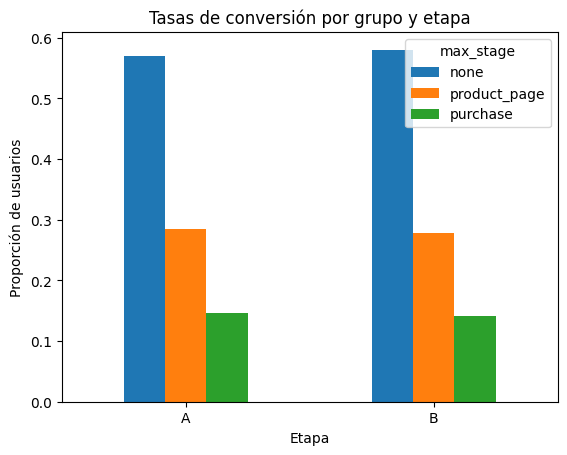

In [11]:
# Unir los DataFrames
data = pd.merge(new_users, events, on='user_id')
data = pd.merge(data, participants, on='user_id') 

# Crear una columna para la etapa más avanzada
conditions = [
    data['event_name'] == 'purchase',
    data['event_name'] == 'product_card',
    data['event_name'] == 'product_page'
]
choices = ['purchase', 'product_card', 'product_page']
data['max_stage'] = np.select(conditions, choices, default='none')

# Calcular las tasas de conversión
conversion_rates = data.groupby(['group', 'max_stage']).size() / data.groupby('group').size()

print(conversion_rates)

# Visualizar las tasas de conversión como un gráfico de líneas
conversion_rates.unstack().plot(kind='bar')
plt.title('Tasas de conversión por grupo y etapa')
plt.xlabel('Etapa')
plt.ylabel('Proporción de usuarios')
plt.xticks(rotation=0)
plt.show()


In [12]:
#Número de eventos que hay 
print('Número de eventos:', events['event_name'].count())

#Número de usuarios 
print('Número de usuarios:', events['user_id'].nunique())

#Promedio de eventos por usuario
print('Número promedio de eventos por usuario:', events.groupby('user_id')['event_name'].count().mean())

Número de eventos: 423761
Número de usuarios: 58703
Número promedio de eventos por usuario: 7.218728174028585


       user_id
group         
A         7874
B         6205


C:\Users\Cecilia Moyaho\AppData\Local\Temp\ipykernel_11296\2356787490.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="user_id", y="group", data=users_by_group, label="Total", palette= custom_colors)
C:\Users\Cecilia Moyaho\AppData\Local\Temp\ipykernel_11296\2356787490.py:7: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(x="user_id", y="group", data=users_by_group, label="Total", palette= custom_colors)


Text(0.5, 1.0, 'Número de usuarios por grupo')

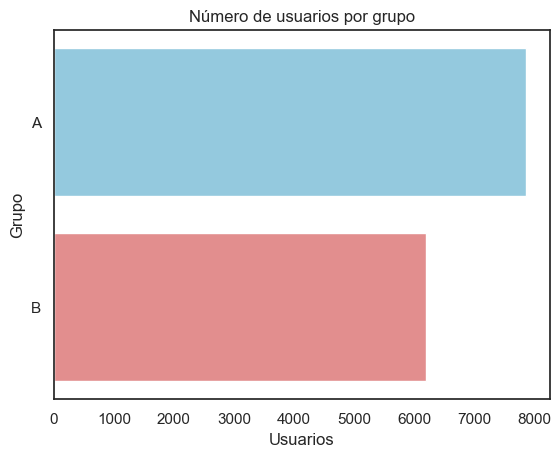

In [13]:
#Visualización de número de usuario por grupo 
users_by_group= participants.groupby('group').agg({'user_id':'nunique'})
print(users_by_group)

sns.set_theme(style="white")
custom_colors = ["skyblue", "lightcoral", "gold", "lightgreen","plum"]
sns.barplot(x="user_id", y="group", data=users_by_group, label="Total", palette= custom_colors)

plt.xlabel("Usuarios")
plt.ylabel("Grupo")
plt.title("Número de usuarios por grupo")

                         user_id
ab_test                         
interface_eu_test          10850
recommender_system_test     3675


C:\Users\Cecilia Moyaho\AppData\Local\Temp\ipykernel_11296\2725525333.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="user_id", y="ab_test", data=users_by_samples, label="Total", palette= custom_colors)
C:\Users\Cecilia Moyaho\AppData\Local\Temp\ipykernel_11296\2725525333.py:7: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(x="user_id", y="ab_test", data=users_by_samples, label="Total", palette= custom_colors)


Text(0.5, 1.0, 'Número de usuarios por muestra')

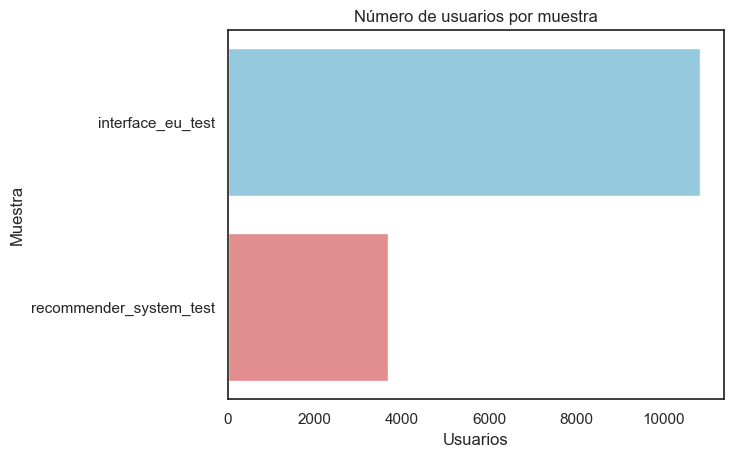

In [14]:
users_by_samples = participants.groupby('ab_test').agg({'user_id':'nunique'})
print(users_by_samples)


sns.set_theme(style="white")
custom_colors = ["skyblue", "lightcoral", "gold", "lightgreen","plum"]
sns.barplot(x="user_id", y="ab_test", data=users_by_samples, label="Total", palette= custom_colors)

plt.xlabel("Usuarios")
plt.ylabel("Muestra")
plt.title("Número de usuarios por muestra")


In [22]:
#Proporción de usuarios por evento 
proportion= data.groupby('event_name', as_index=False).agg({'user_id': 'nunique'}).sort_values(by="user_id", ascending=False)
proportion

,event_name,user_id
0,login,13636
2,product_page,8923
3,purchase,4563
1,product_cart,4394


In [23]:
#Proporción de usuarios por evento y grupo 'A'
data_A = data[data['group']== 'A']
proportion_A= data_A.groupby('event_name', as_index=False).agg({'user_id': 'nunique'}).sort_values(by='user_id', ascending=False)
proportion_A

,event_name,user_id
0,login,7873
2,product_page,5208
3,purchase,2682
1,product_cart,2483


In [24]:
#Proporción de usuarios por evento y grupo 'B'
data_B= data[data['group']== 'B']
proportion_B = data_B.groupby("event_name", as_index=False).agg({"user_id": "nunique"}).sort_values(by="user_id", ascending=False)
proportion_B

,event_name,user_id
0,login,6204
2,product_page,3986
1,product_cart,2037
3,purchase,2008


In [67]:
#Encontrar si hay una diferencia estadísticamente significativa entre las muestras 'interface_eu_test' y 'recommender_system_test'.

#Dividir por muestras
data_A = data[data['ab_test']== 'interface_eu_test']
data_B = data[data['ab_test']== 'recommender_system_test']

#Verificar si el número de usuarios es igual en ambos grupos
if len(data_A) == len(data_B):
    # Utilizar t-test para comparar el promerio de Eventos entre los dos grupos
    tstatistic, pvalue = stats.ttest_ind(data_A["Event_Name"], data_B["Event_Name"])

    #Comprobar si p-value es menor que el nivel de significancia (alpha)
    if pvalue < 0.05:
        print(
            f"Existe una diferencia estadísticamente significativa (p-valor = {pvalue}) entre el número de eventos en el grupo de control 'interface_eu_test' y el grupo de control 'recommender_system_test'."
        )
    else:
        print(
            "No existe una diferencia estadísticamente significativa (p-valor = {pvalue}) entre el número de eventos en el grupo de control 'interface_eu_test' y el grupo de control 'recommender_system_test'."
        )
else:
    print(
        "El número de usuarios en los grupos de control 'interface_eu_test' y 'recommender_system_test' no es igual. No se puede realizar una prueba estadística en este caso."
    )

El número de usuarios en los grupos de control 'interface_eu_test' y 'recommender_system_test' no es igual. No se puede realizar una prueba estadística en este caso.


In [32]:
common_users = participants['user_id'].duplicated().sum()
print('Número de participantes que están presentes en ambas pruebas:', common_users)

Número de participantes que están presentes en ambas pruebas: 887


Text(0.5, 1.0, 'Distribución de eventos entre los días')

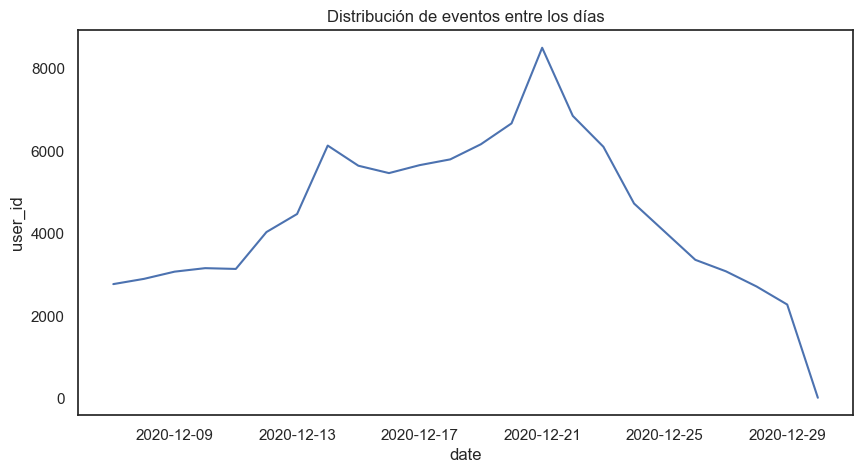

In [39]:
data["date"] = data["event_dt"].dt.date

plt.figure(figsize=(10,5))
sns.lineplot(data=data.groupby('date')['user_id'].count().reset_index(), x='date', y='user_id')
plt.xticks(rotation=0)
plt.title('Distribución de eventos entre los días')

In [73]:
#Embudo de eventos
users_by_event= events.groupby('event_name').agg({'user_id':'nunique'})
print(users_by_event)

users_by_event["Users_In_Previous_Step"] = users_by_event["user_id"].shift(1)
users_by_event["Conversion_Rate"] = users_by_event["user_id"] / \
    users_by_event["Users_In_Previous_Step"]
users_by_event["Dropoff_Rate"] = 1 - users_by_event["Conversion_Rate"]

users_by_event.head()

              user_id
event_name           
login           58696
product_cart    19284
product_page    38929
purchase        19568


,user_id,Users_In_Previous_Step,Conversion_Rate,Dropoff_Rate
event_name,,,,
login,58696,NaN,NaN,NaN
product_cart,19284,58696.0,0.328540,0.671460
product_page,38929,19284.0,2.018720,-1.018720
purchase,19568,38929.0,0.502659,0.497341


- La tasa de conversión entre "login" y "product_cart" es del 32.85%, lo que indica que aproximadamente un tercio de los usuarios que inician sesión agregan productos al carrito.
- Sin embargo, la tasa de conversión entre "product_cart" y "product_page" es de 2.0187, lo cual no tiene sentido como una tasa de conversión. Esto podría indicar un error en los datos o en el cálculo.
- La tasa de conversión entre "product_page" y "purchase" es del 50.26%, lo que significa que la mitad de los usuarios que visitan la página del producto realizan una compra.

C:\Users\Cecilia Moyaho\AppData\Local\Temp\ipykernel_11296\1950897045.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_A["date"] = data_A["event_dt"].dt.date


         date    event_name  user_id
0  2020-12-07         login      903
1  2020-12-07  product_cart      270
2  2020-12-07  product_page      586
3  2020-12-07      purchase      309
4  2020-12-08         login      996


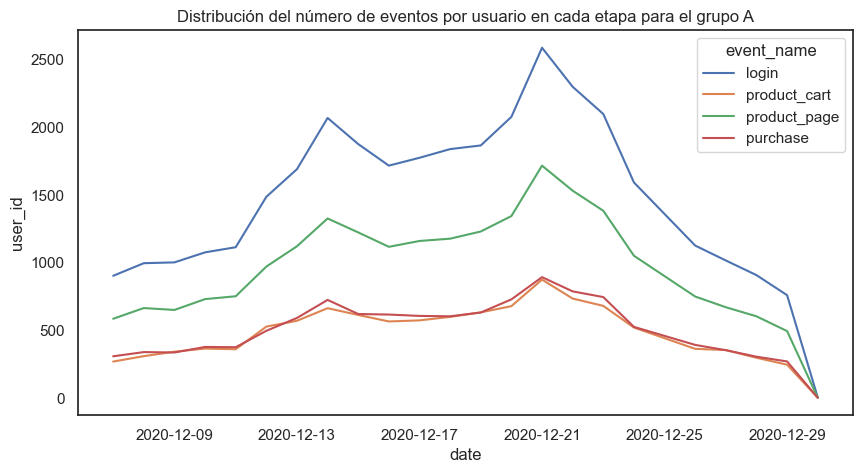

In [74]:
# Distribución del número de eventos por usuario en cada etapa para el grupo A
data_A["date"] = data_A["event_dt"].dt.date

day_counts_A = data_A.groupby(["date", "event_name"], as_index=False)["user_id"].count()
print(day_counts_A.head())

plt.figure(figsize=(10,5))
sns.lineplot(data=day_counts_A, x="date", y="user_id", hue="event_name")
plt.title('Distribución del número de eventos por usuario en cada etapa para el grupo A')
plt.show()

C:\Users\Cecilia Moyaho\AppData\Local\Temp\ipykernel_11296\3666771595.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_B["date"] = data_B["event_dt"].dt.date


         date    event_name  user_id
0  2020-12-07         login      319
1  2020-12-07  product_cart       81
2  2020-12-07  product_page      204
3  2020-12-07      purchase      105
4  2020-12-08         login      278


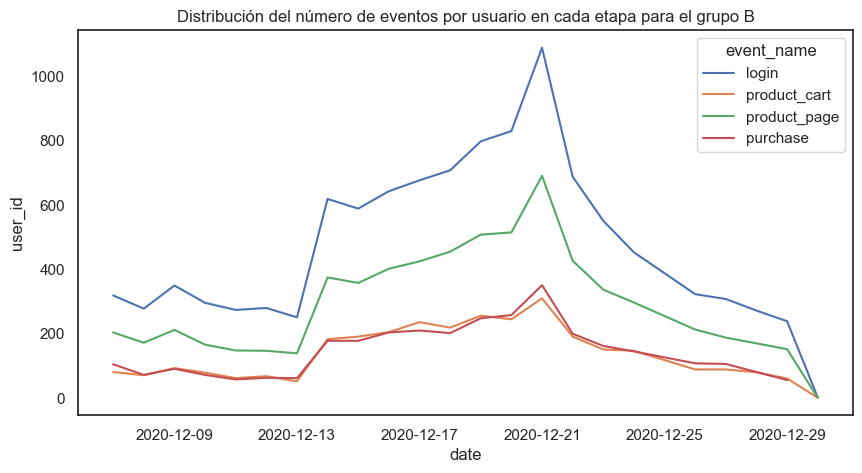

In [75]:
# Distribución del número de eventos por usuario en cada etapa para el grupo A
data_B["date"] = data_B["event_dt"].dt.date

day_counts_B = data_B.groupby(["date", "event_name"], as_index=False)["user_id"].count()
print(day_counts_B.head())

plt.figure(figsize=(10,5))
sns.lineplot(data=day_counts_B, x="date", y="user_id", hue="event_name")
plt.title('Distribución del número de eventos por usuario en cada etapa para el grupo B')
plt.show()

### 7. Prueba Z
---

- Hipótesis nula (H0): No hay diferencia significativa en las tasas de conversión entre los grupos A y B.
- Hipótesis alternativa (H1): La tasa de conversión en el grupo B es mayor que en el grupo A.

In [71]:
def z_test(stage, next_stage):
    """
    Realiza una prueba Z para comparar las proporciones de conversión entre dos etapas de un embudo.

    Args:
        etapa: Nombre de la etapa inicial en el embudo.
        siguiente_etapa: Nombre de la siguiente etapa en el embudo.
    """

    data_A = data[data['group'] == 'A']  # Filtra los datos del grupo A
    data_B = data[data['group'] == 'B']  # Filtra los datos del grupo B

    # Cuenta los usuarios únicos que alcanzaron cada etapa en cada grupo
    event_A = data_A[data_A['event_name']==stage]['user_id'].nunique()
    event_B = data_B[data_B['event_name']==stage]['user_id'].nunique()
    next_stage_A = data_A[data_A['event_name']== next_stage]['user_id'].nunique()
    next_stage_B = data_B[data_B['event_name']== next_stage]['user_id'].nunique()

    alpha = 0.5 # Nivel de significancia

    # Calcula las proporciones de conversión y la proporción combinada
    next_events = np.array([next_stage_A, next_stage_B])
    events = np.array([event_A, event_B])
    p1 = next_events[0]/events[0]
    p2 = next_events[1]/events[1]
    p_combined = (next_events[0] + next_events[1])/(events[0] + events[1])
    difference = p1-p2

    # Calcula el estadístico Z
    z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/events[0] + 1/events[1]))

    # Calcula el valor p
    distr = st.norm(0,1)
# Calcula el valor p (unilateral)
    p_value = 1 - distr.cdf(z_value)

    print('p-value:', p_value)

    # Toma una decisión basada en el valor p
    if (p_value < alpha):
        print('Rechazar la hipótesis nula: La tasa de conversión en el grupo B es significativamente mayor que en el grupo A.')
    else:
        print('No se pudo rechazar la hipótesis nula: No hay evidencia suficiente para concluir que la tasa de conversión en B es mayor que en A.')

# Z_test de proporciones por cada evento
print('Event: Product_page')
z_test('login','product_page')
print('Event: Purchase')
z_test('product_page','purchase')
print('Event: Product_cart')
z_test('purchase','product_cart')
print('=====================================================================================================================================')
# Z test de proporciones para 'login'
funnel = ["product_page", "product_cart", "purchase"]

for element in funnel:
    print(f"\tEvent: {element}:")
    z_test("login", element)


Event: Product_page
p-value: 0.009313293968279401
Rechazar la hipótesis nula: La tasa de conversión en el grupo B es significativamente mayor que en el grupo A.
Event: Purchase
p-value: 0.1432307465846775
Rechazar la hipótesis nula: La tasa de conversión en el grupo B es significativamente mayor que en el grupo A.
Event: Product_cart
p-value: 1.0
No se pudo rechazar la hipótesis nula: No hay evidencia suficiente para concluir que la tasa de conversión en B es mayor que en A.
	Event: product_page:
p-value: 0.009313293968279401
Rechazar la hipótesis nula: La tasa de conversión en el grupo B es significativamente mayor que en el grupo A.
	Event: product_cart:
p-value: 0.9489148717938636
No se pudo rechazar la hipótesis nula: No hay evidencia suficiente para concluir que la tasa de conversión en B es mayor que en A.
	Event: purchase:
p-value: 0.016835455057593096
Rechazar la hipótesis nula: La tasa de conversión en el grupo B es significativamente mayor que en el grupo A.


### 8. Conclusiones
---

EDA

Durante la visualización de los diferentes dataset, encontramos que no existen valores ausentes en 3 de los 4 dataset. El dataset 'events' es dónde se encontrarón 363,447 que representa el 86% del total de los datos. 

- Los datos faltantes se concentran principalmente en el evento "login".
- La alta proporción de valores faltantes en "details" no justifica la eliminación de filas o columnas.
- No es necesario reemplazar los valores faltantes en este caso.
- Se recomienda realizar un análisis más detallado para entender las razones detrás de los valores faltantes en "login"

No es necesario eliminar filas o columnas: Dado que los valores faltantes se concentran principalmente en el evento "login" y no afectan significativamente a otros eventos, no es necesario eliminar filas o columnas completas del conjunto de datos. Eliminar datos podría llevar a una pérdida de información valiosa.

No es necesario reemplazar valores faltantes: En este caso particular, reemplazar los valores faltantes con un valor promedio, moda o otro valor imputado podría no ser la mejor opción, ya que podría introducir sesgos en el análisis.

Por otro lado, en los otros dataset solo hubo que hacer cambio en el tipo de datos de datos que contenian fechas. 

TEST A/B

- Al analizar los datos del A/B test, se identificó un desajuste entre el número de usuarios únicos registrados (3675) y el objetivo establecido en las especificaciones técnicas (6000). Un tamaño de muestra insuficiente puede comprometer la precisión y la robustez de las conclusiones derivadas de este experimento, ya que limita la capacidad de detectar diferencias estadísticamente significativas

- Los resultados de la prueba A/B sugieren que el nuevo sistema de recomendaciones (Grupo B) tuvo un impacto significativo en algunas etapas del embudo de conversión, pero no en otras.

- Product_page: El grupo B mostró una tasa de conversión significativamente mayor en la etapa de visualización de la página del producto. Esto indica que el nuevo sistema de recomendaciones está haciendo un mejor trabajo al atraer a los usuarios a los productos relevantes.
- Product_cart: No se encontró una diferencia significativa entre los grupos en esta etapa. Esto sugiere que el nuevo sistema no está teniendo un impacto significativo en la decisión de los usuarios de agregar productos al carrito.
- Purchase: El grupo B también mostró una tasa de conversión significativamente mayor en la etapa de compra. Esto indica que el nuevo sistema está ayudando a convertir a más visitantes en clientes.

- La falta de equilibrio en la distribución de usuarios entre los grupos A y B limita la aplicabilidad del Z-test para comparar las tasas de conversión en todas las etapas del embudo. Aunque el test indica una mejora general, no proporciona una visión completa del impacto del nuevo sistema de recomendaciones. Un análisis más profundo, que considere las características específicas de cada etapa y los diferentes segmentos de usuarios, es necesario para identificar las áreas de oportunidad y optimizar el proceso de conversión.




